In [2]:
# !pip install --upgrade pip
# !pip install xgboost 

In [1]:
import os 
import random
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
base_dir = './dataset/'

import os 
import pandas as pd
import numpy as np
from copy import deepcopy

test_df = pd.read_csv(os.path.join(base_dir, 'test_dataset.csv'))
valid_df = pd.read_csv(os.path.join(base_dir, 'validation_dataset.csv'))
train_df = pd.read_csv(os.path.join(base_dir, 'train_dataset.csv'))

print('Training dataset:', train_df.shape)
print('Validation dataset:', valid_df.shape)
print('Test dataset:', test_df.shape)

Training dataset: (8644, 5)
Validation dataset: (500, 5)
Test dataset: (500, 5)


In [4]:
def uncertainty_active_learner(data, b_size, probs):
    
    # step 1: find the higher probability
    # step 2: sort these probabilities
    # step 3: choose the ones that have the lowest probability
    sorted_arg = np.argsort(np.amax(probs, axis=1))
    
    sampled = data.drop(list(sorted_arg[b_size:]))
    remaining = data.drop(list(sorted_arg[:b_size]))

    return sampled, remaining

In [5]:
def random_active_learner(data, b_size=10, seed=0):
    sampled = data.sample(n=b_size, random_state=seed)
    remaining = data.drop(sampled.index)

    return sampled, remaining
    

In [6]:
sentence_ids = pickle.load(open('bert_sentence_ids.pkl', 'rb'))
sentences_embeds = pickle.load(open('bert_sentence_embeddings.pkl', 'rb'))

def to_features(data):
    X = np.zeros((data.shape[0], 768))
    Y = np.zeros((data.shape[0], 1), dtype=bool)
    
    for i in range(data.shape[0]):
        s_id = sentence_ids[data.iloc[i]['question'] + ' ||| ' + data.iloc[i]['answer']]
        X[i, :] = sentences_embeds[s_id]
        Y[i, :] = data.iloc[i]['label']
        
    return X, Y

In [7]:
def eval_results(model, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics):
    Y_train_pred = model.predict(X_train)
    train_predictions = [round(value) for value in Y_train_pred]
    train_accuracy = accuracy_score(Y_train, train_predictions)
    train_f1 = f1_score(Y_train, train_predictions)
    print('Train accuracy:', train_accuracy, ' - Train f1:', train_f1)

    Y_valid_pred = model.predict(X_valid)
    valid_predictions = [round(value) for value in Y_valid_pred]
    valid_accuracy = accuracy_score(Y_valid, valid_predictions)
    valid_f1 = f1_score(Y_valid, valid_predictions)
    print('Valid accuracy:', valid_accuracy, ' - Valid f1:', valid_f1)

    Y_test_pred = model.predict(X_test)
    test_predictions = [round(value) for value in Y_test_pred]
    test_accuracy = accuracy_score(Y_test, test_predictions)
    test_f1 = f1_score(Y_test, test_predictions)
    print('Test accuracy:', test_accuracy, ' - Test f1:', test_f1)

    eval_metrics.append([train_accuracy, train_f1, valid_accuracy, valid_f1, test_accuracy, test_f1])
    return test_accuracy, test_f1

In [22]:
seed = 1
set_random_seed(seed)

batch_size = 10

pool_df = deepcopy(train_df)
pool_df.reset_index(drop=True, inplace=True)
annotated_df = pd.DataFrame(columns=pool_df.columns)

seed_df, pool_no_seed_df = random_active_learner(data=pool_df, 
                                               b_size=batch_size, 
                                               seed=seed)

pool_df.reset_index(drop=True, inplace=True)
seed_df.reset_index(drop=True, inplace=True)    

#X_train, Y_train = to_features(pool_df)
X_train, Y_train = to_features(seed_df)
X_valid, Y_valid = to_features(valid_df)
X_test, Y_test = to_features(test_df)
    
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(np.unique(Y_train))
print(np.unique(Y_valid))
print(np.unique(Y_test))

(10, 768)
(500, 768)
(500, 768)
[False  True]
[False  True]
[False  True]


In [23]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
print('Started fitting...')
clf.fit(X_train, Y_train)
print('Finished fitting.')

eval_metrics = []
print('Started predicting...')
acc, f1 = eval_results(clf, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
print('Finished predicting.')
pickle.dump(clf, open('svm_start_model.pkl', "wb"))
print(acc, f1)

Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.914  - Valid f1: 0.929853181076672
Test accuracy: 0.914  - Test f1: 0.9284525790349419
Finished predicting.
0.914 0.9284525790349419


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
batch_size = 50

strategy_results = {}
for al_strategy in ['uncertainty', 'random']:
    print("Using {} Strategy ====>".format(al_strategy))
    al_iterations = 30
    
    eval_metrics = []
    
    clf = pickle.load(open('svm_start_model.pkl', "rb"))
    print('Started predicting...')
    acc, f1 = eval_results(clf, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
    print('Finished predicting.')

    pool_df = deepcopy(pool_no_seed_df)
    pool_df.reset_index(drop=True, inplace=True)
    annotated_df = deepcopy(seed_df)
    print('Pool size:', pool_df.shape, ' - Annotated size:', annotated_df.shape)
    
    f1_list = [f1]
    acc_list = [acc]
    
    for i in range(al_iterations):
        print('********** AL Iteration', i, '**************')

        print('Evaluate pool dataset...')
        X_pool, Y_pool = to_features(pool_df)
        predicted_prob = clf.predict_proba(X_pool)
        print('Evaluation Done.')

        if al_strategy == 'random':
            to_annotate_i, pool_df = random_active_learner(data=pool_df, 
                                                   b_size=batch_size, 
                                                   seed=seed)
        elif al_strategy == 'uncertainty':
            to_annotate_i, pool_df = uncertainty_active_learner(data=pool_df, 
                                                        b_size=batch_size, 
                                                        probs=predicted_prob)
        elif al_strategy == 'uncertainty_diversity':
            to_annotate_i, pool_df = uncertainty_diversity_active_learner(data=pool_df, 
                                                                          b_size=batch_size, 
                                                                          probs=predicted_prob)
        elif al_strategy == 'clustering':
            to_annotate_i, pool_df = clustering_active_learner(data=pool_df, 
                                                              b_size=batch_size, 
                                                              probs=predicted_prob)
        else:
            print('ERROR: Wrong AL Option.')
            break

        pool_df.reset_index(drop=True, inplace=True)
        to_annotate_i.reset_index(drop=True, inplace=True)

        annotated_df = pd.concat([annotated_df, to_annotate_i], axis=0, join='outer')
        annotated_df.reset_index(drop=True, inplace=True)

        print('Pool:', pool_df.shape, ' - to_annotate_i:', to_annotate_i.shape, ' - annotated:', annotated_df.shape)

        print('Creating features...')
        X_train, Y_train = to_features(annotated_df)
        print('Features created.')

        print('Started fitting...')
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
        clf.fit(X_train, Y_train)
        print('Finished fitting.')

        print('Started predicting...')
        acc, f1 = eval_results(clf, X_train, Y_train, X_valid, Y_valid, X_test, Y_test, eval_metrics)
        acc_list.append(acc)
        f1_list.append(f1)
        print('Finished predicting.')
    strategy_results[al_strategy] = [acc_list, f1_list] 

Using uncertainty Strategy ====>
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.914  - Valid f1: 0.929853181076672
Test accuracy: 0.914  - Test f1: 0.9284525790349419
Finished predicting.
Pool size: (8634, 5)  - Annotated size: (10, 5)
********** AL Iteration 0 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8584, 5)  - to_annotate_i: (50, 5)  - annotated: (60, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.88  - Valid f1: 0.8901098901098901
Test accuracy: 0.848  - Test f1: 0.8538461538461539
Finished predicting.
********** AL Iteration 1 **************
Evaluate pool dataset...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation Done.
Pool: (8534, 5)  - to_annotate_i: (50, 5)  - annotated: (110, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Valid accuracy: 0.97  - Valid f1: 0.9748743718592964
Test accuracy: 0.962  - Test f1: 0.9672977624784854
Finished predicting.
********** AL Iteration 2 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8484, 5)  - to_annotate_i: (50, 5)  - annotated: (160, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.99375  - Train f1: 0.9924812030075187
Valid accuracy: 0.974  - Valid f1: 0.9780775716694773
Test accuracy: 0.97  - Test f1: 0.9740932642487047
Finished predicting.
********** AL Iteration 3 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8434, 5)  - to_annotate_i: (50, 5)  - annotated: (210, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9952380952380953  - Train f1: 0.994475138121547
Valid accuracy: 0.972  - Valid f1: 0.9764309764309763
Test accuracy: 0.986  - Test f1: 0.9879931389365352
Finished predicting.
********** AL Iteration 4 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8384, 5)  - to_annotate_i: (50, 5)  - annotated: (260, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9961538461538462  - Train f1: 0.9957446808510638
Valid accuracy: 0.978  - Valid f1: 0.9815126050420168
Test accuracy: 0.994  - Test f1: 0.9948542024013721
Finished predicting.
********** AL Iteration 5 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8334, 5)  - to_annotate_i: (50, 5)  - annotated: (310, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9967741935483871  - Train f1: 0.9964664310954063
Valid accuracy: 0.984  - Valid f1: 0.9865319865319865
Test accuracy: 0.99  - Test f1: 0.9913941480206541
Finished predicting.
********** AL Iteration 6 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8284, 5)  - to_annotate_i: (50, 5)  - annotated: (360, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9972222222222222  - Train f1: 0.9969230769230769
Valid accuracy: 0.986  - Valid f1: 0.988155668358714
Test accuracy: 0.984  - Test f1: 0.986159169550173
Finished predicting.
********** AL Iteration 7 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8234, 5)  - to_annotate_i: (50, 5)  - annotated: (410, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.986  - Valid f1: 0.9882352941176471
Test accuracy: 0.992  - Test f1: 0.9931506849315068
Finished predicting.
********** AL Iteration 8 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8184, 5)  - to_annotate_i: (50, 5)  - annotated: (460, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9934782608695653  - Train f1: 0.9930394431554525
Valid accuracy: 0.982  - Valid f1: 0.984822934232715
Test accuracy: 0.992  - Test f1: 0.9931506849315068
Finished predicting.
********** AL Iteration 9 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8134, 5)  - to_annotate_i: (50, 5)  - annotated: (510, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9921568627450981  - Train f1: 0.9918367346938776
Valid accuracy: 0.992  - Valid f1: 0.9932885906040269
Test accuracy: 0.992  - Test f1: 0.9931506849315068
Finished predicting.
********** AL Iteration 10 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8084, 5)  - to_annotate_i: (50, 5)  - annotated: (560, 5)
Creating features...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9946428571428572  - Train f1: 0.9945553539019965
Valid accuracy: 0.992  - Valid f1: 0.9932885906040269
Test accuracy: 0.996  - Test f1: 0.9965753424657534
Finished predicting.
********** AL Iteration 11 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8034, 5)  - to_annotate_i: (50, 5)  - annotated: (610, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9934426229508196  - Train f1: 0.9936908517350158
Valid accuracy: 0.99  - Valid f1: 0.9916247906197654
Test accuracy: 0.994  - Test f1: 0.9948717948717949
Finished predicting.
********** AL Iteration 12 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7984, 5)  - to_annotate_i: (50, 5)  - annotated: (660, 5)
Creating features...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9924242424242424  - Train f1: 0.9927431059506531
Valid accuracy: 0.99  - Valid f1: 0.9916247906197654
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 13 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7934, 5)  - to_annotate_i: (50, 5)  - annotated: (710, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9929577464788732  - Train f1: 0.9931787175989086
Valid accuracy: 0.992  - Valid f1: 0.9932885906040269
Test accuracy: 0.998  - Test f1: 0.9982905982905983
Finished predicting.
********** AL Iteration 14 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7884, 5)  - to_annotate_i: (50, 5)  - annotated: (760, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9881578947368421  - Train f1: 0.988679245283019
Valid accuracy: 0.99  - Valid f1: 0.9916247906197654
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 15 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7834, 5)  - to_annotate_i: (50, 5)  - annotated: (810, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.991358024691358  - Train f1: 0.991869918699187
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 16 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7784, 5)  - to_annotate_i: (50, 5)  - annotated: (860, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9872093023255814  - Train f1: 0.9883351007423118
Valid accuracy: 0.99  - Valid f1: 0.9916247906197654
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 17 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7734, 5)  - to_annotate_i: (50, 5)  - annotated: (910, 5)
Creating features...
Features created.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9857142857142858  - Train f1: 0.987012987012987
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 18 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7684, 5)  - to_annotate_i: (50, 5)  - annotated: (960, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9885416666666667  - Train f1: 0.98989898989899
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 19 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7634, 5)  - to_annotate_i: (50, 5)  - annotated: (1010, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9841584158415841  - Train f1: 0.9863247863247864
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 20 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7584, 5)  - to_annotate_i: (50, 5)  - annotated: (1060, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9858490566037735  - Train f1: 0.98812351543943
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 21 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7534, 5)  - to_annotate_i: (50, 5)  - annotated: (1110, 5)
Creating features...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9855855855855856  - Train f1: 0.98796992481203
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 22 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7484, 5)  - to_annotate_i: (50, 5)  - annotated: (1160, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9862068965517241  - Train f1: 0.9885550786838341
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 23 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7434, 5)  - to_annotate_i: (50, 5)  - annotated: (1210, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9867768595041322  - Train f1: 0.9890260631001372
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 24 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7384, 5)  - to_annotate_i: (50, 5)  - annotated: (1260, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9873015873015873  - Train f1: 0.9895833333333334
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 25 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7334, 5)  - to_annotate_i: (50, 5)  - annotated: (1310, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9877862595419847  - Train f1: 0.9899497487437185
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 26 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7284, 5)  - to_annotate_i: (50, 5)  - annotated: (1360, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9882352941176471  - Train f1: 0.9904534606205251
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 27 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7234, 5)  - to_annotate_i: (50, 5)  - annotated: (1410, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9879432624113476  - Train f1: 0.9903354178510517
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 28 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7184, 5)  - to_annotate_i: (50, 5)  - annotated: (1460, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9883561643835617  - Train f1: 0.9907053034445052
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
********** AL Iteration 29 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7134, 5)  - to_annotate_i: (50, 5)  - annotated: (1510, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9887417218543046  - Train f1: 0.990990990990991
Valid accuracy: 0.988  - Valid f1: 0.9899328859060402
Test accuracy: 0.996  - Test f1: 0.9965870307167235
Finished predicting.
Using random Strategy ====>
Started predicting...
Train accuracy: 0.6887417218543046  - Train f1: 0.7746883988494727
Valid accuracy: 0.914  - Valid f1: 0.929853181076672
Test accuracy: 0.914  - Test f1: 0.9284525790349419
Finished predicting.
Pool size: (8634, 5)  - Annotated size: (10, 5)
********** AL Iteration 0 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8584, 5)  - to_annotate_i: (50, 5)  - annotated: (60, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.934  - Valid f1: 0.9445378151260505
Test accuracy: 0.936  - Test f1: 0.9450171821305842
Finished predicting.
********** AL Iteration 1 **************
Evaluate pool dataset...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation Done.
Pool: (8534, 5)  - to_annotate_i: (50, 5)  - annotated: (110, 5)
Creating features...
Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 1.0  - Train f1: 1.0
Valid accuracy: 0.942  - Valid f1: 0.9514237855946399


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test accuracy: 0.942  - Test f1: 0.9499136442141624
Finished predicting.
********** AL Iteration 2 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8484, 5)  - to_annotate_i: (50, 5)  - annotated: (160, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.99375  - Train f1: 0.994535519125683
Valid accuracy: 0.956  - Valid f1: 0.9632107023411371
Test accuracy: 0.954  - Test f1: 0.9608177172061328
Finished predicting.
********** AL Iteration 3 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8434, 5)  - to_annotate_i: (50, 5)  - annotated: (210, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9904761904761905  - Train f1: 0.9917355371900827
Valid accuracy: 0.962  - Valid f1: 0.9681742043551089
Test accuracy: 0.968  - Test f1: 0.9730639730639731
Finished predicting.
********** AL Iteration 4 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8384, 5)  - to_annotate_i: (50, 5)  - annotated: (260, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9923076923076923  - Train f1: 0.9933774834437086
Valid accuracy: 0.962  - Valid f1: 0.9682804674457429
Test accuracy: 0.97  - Test f1: 0.9746192893401014
Finished predicting.
********** AL Iteration 5 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8334, 5)  - to_annotate_i: (50, 5)  - annotated: (310, 5)
Creating features...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9935483870967742  - Train f1: 0.9944134078212291
Valid accuracy: 0.96  - Valid f1: 0.9665551839464883
Test accuracy: 0.97  - Test f1: 0.9745331069609509
Finished predicting.
********** AL Iteration 6 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8284, 5)  - to_annotate_i: (50, 5)  - annotated: (360, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9944444444444445  - Train f1: 0.9952606635071091
Valid accuracy: 0.96  - Valid f1: 0.9665551839464883
Test accuracy: 0.966  - Test f1: 0.9712351945854485
Finished predicting.
********** AL Iteration 7 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8234, 5)  - to_annotate_i: (50, 5)  - annotated: (410, 5)
Creating features...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features created.
Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9951219512195122  - Train f1: 0.995798319327731
Valid accuracy: 0.96  - Valid f1: 0.9666666666666668
Test accuracy: 0.968  - Test f1: 0.9728813559322035
Finished predicting.
********** AL Iteration 8 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8184, 5)  - to_annotate_i: (50, 5)  - annotated: (460, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9956521739130435  - Train f1: 0.9962264150943396
Valid accuracy: 0.966  - Valid f1: 0.9717138103161398
Test accuracy: 0.97  - Test f1: 0.9745331069609509
Finished predicting.
********** AL Iteration 9 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8134, 5)  - to_annotate_i: (50, 5)  - annotated: (510, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9941176470588236  - Train f1: 0.9948364888123924
Valid accuracy: 0.97  - Valid f1: 0.9750415973377704
Test accuracy: 0.968  - Test f1: 0.9727891156462585
Finished predicting.
********** AL Iteration 10 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8084, 5)  - to_annotate_i: (50, 5)  - annotated: (560, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9946428571428572  - Train f1: 0.995260663507109
Valid accuracy: 0.97  - Valid f1: 0.9749582637729549
Test accuracy: 0.974  - Test f1: 0.9779286926994906
Finished predicting.
********** AL Iteration 11 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8034, 5)  - to_annotate_i: (50, 5)  - annotated: (610, 5)
Creating features...
Features created.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Started fitting...
Finished fitting.
Started predicting...
Train accuracy: 0.9950819672131147  - Train f1: 0.9956584659913169
Valid accuracy: 0.972  - Valid f1: 0.9766666666666666
Test accuracy: 0.974  - Test f1: 0.9779286926994906
Finished predicting.
********** AL Iteration 12 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7984, 5)  - to_annotate_i: (50, 5)  - annotated: (660, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9954545454545455  - Train f1: 0.9959946595460616
Valid accuracy: 0.972  - Valid f1: 0.9766666666666666
Test accuracy: 0.978  - Test f1: 0.9812606473594548
Finished predicting.
********** AL Iteration 13 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7934, 5)  - to_annotate_i: (50, 5)  - annotated: (710, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.995774647887324  - Train f1: 0.9962358845671268
Valid accuracy: 0.972  - Valid f1: 0.9766666666666666
Test accuracy: 0.978  - Test f1: 0.9812606473594548
Finished predicting.
********** AL Iteration 14 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7884, 5)  - to_annotate_i: (50, 5)  - annotated: (760, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9960526315789474  - Train f1: 0.9964830011723328
Valid accuracy: 0.974  - Valid f1: 0.9782971619365609
Test accuracy: 0.978  - Test f1: 0.9812606473594548
Finished predicting.
********** AL Iteration 15 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7834, 5)  - to_annotate_i: (50, 5)  - annotated: (810, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9962962962962963  - Train f1: 0.9967355821545157
Valid accuracy: 0.974  - Valid f1: 0.978369384359401
Test accuracy: 0.984  - Test f1: 0.9864406779661017
Finished predicting.
********** AL Iteration 16 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7784, 5)  - to_annotate_i: (50, 5)  - annotated: (860, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9965116279069768  - Train f1: 0.9969293756397134
Valid accuracy: 0.974  - Valid f1: 0.978369384359401
Test accuracy: 0.984  - Test f1: 0.9864406779661017
Finished predicting.
********** AL Iteration 17 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7734, 5)  - to_annotate_i: (50, 5)  - annotated: (910, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9967032967032967  - Train f1: 0.9971014492753623
Valid accuracy: 0.976  - Valid f1: 0.9800664451827243
Test accuracy: 0.984  - Test f1: 0.9864406779661017
Finished predicting.
********** AL Iteration 18 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7684, 5)  - to_annotate_i: (50, 5)  - annotated: (960, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.996875  - Train f1: 0.9972602739726028
Valid accuracy: 0.976  - Valid f1: 0.9800664451827243
Test accuracy: 0.984  - Test f1: 0.9864406779661017
Finished predicting.
********** AL Iteration 19 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7634, 5)  - to_annotate_i: (50, 5)  - annotated: (1010, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.996039603960396  - Train f1: 0.9965397923875432
Valid accuracy: 0.976  - Valid f1: 0.9800664451827243
Test accuracy: 0.984  - Test f1: 0.9864406779661017
Finished predicting.
********** AL Iteration 20 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7584, 5)  - to_annotate_i: (50, 5)  - annotated: (1060, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9971698113207547  - Train f1: 0.9975144987572493
Valid accuracy: 0.976  - Valid f1: 0.9800664451827243
Test accuracy: 0.99  - Test f1: 0.991482112436116
Finished predicting.
********** AL Iteration 21 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7534, 5)  - to_annotate_i: (50, 5)  - annotated: (1110, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9972972972972973  - Train f1: 0.9976359338061467
Valid accuracy: 0.976  - Valid f1: 0.9800664451827243
Test accuracy: 0.99  - Test f1: 0.991482112436116
Finished predicting.
********** AL Iteration 22 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7484, 5)  - to_annotate_i: (50, 5)  - annotated: (1160, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9974137931034482  - Train f1: 0.9977494373593397
Valid accuracy: 0.978  - Valid f1: 0.9816971713810316
Test accuracy: 0.99  - Test f1: 0.991482112436116
Finished predicting.
********** AL Iteration 23 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7434, 5)  - to_annotate_i: (50, 5)  - annotated: (1210, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.996694214876033  - Train f1: 0.9971346704871059
Valid accuracy: 0.978  - Valid f1: 0.9816360601001669
Test accuracy: 0.99  - Test f1: 0.991482112436116
Finished predicting.
********** AL Iteration 24 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7384, 5)  - to_annotate_i: (50, 5)  - annotated: (1260, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9984126984126984  - Train f1: 0.9986206896551724
Valid accuracy: 0.978  - Valid f1: 0.9816360601001669
Test accuracy: 0.99  - Test f1: 0.991482112436116
Finished predicting.
********** AL Iteration 25 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7334, 5)  - to_annotate_i: (50, 5)  - annotated: (1310, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9969465648854962  - Train f1: 0.9973297730307076
Valid accuracy: 0.978  - Valid f1: 0.9816360601001669
Test accuracy: 0.994  - Test f1: 0.9948892674616696
Finished predicting.
********** AL Iteration 26 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7284, 5)  - to_annotate_i: (50, 5)  - annotated: (1360, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9970588235294118  - Train f1: 0.9974259974259975
Valid accuracy: 0.978  - Valid f1: 0.9816360601001669
Test accuracy: 0.994  - Test f1: 0.9948892674616696
Finished predicting.
********** AL Iteration 27 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7234, 5)  - to_annotate_i: (50, 5)  - annotated: (1410, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.997872340425532  - Train f1: 0.9981492905613819
Valid accuracy: 0.98  - Valid f1: 0.9832775919732442
Test accuracy: 0.994  - Test f1: 0.9948892674616696
Finished predicting.
********** AL Iteration 28 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7184, 5)  - to_annotate_i: (50, 5)  - annotated: (1460, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9965753424657534  - Train f1: 0.9970149253731344
Valid accuracy: 0.978  - Valid f1: 0.9815745393634842
Test accuracy: 0.994  - Test f1: 0.9948892674616696
Finished predicting.
********** AL Iteration 29 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (7134, 5)  - to_annotate_i: (50, 5)  - annotated: (1510, 5)
Creating features...
Features created.
Started fitting...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished fitting.
Started predicting...
Train accuracy: 0.9973509933774835  - Train f1: 0.9976931949250288
Valid accuracy: 0.978  - Valid f1: 0.9815745393634842
Test accuracy: 0.994  - Test f1: 0.9948892674616696
Finished predicting.


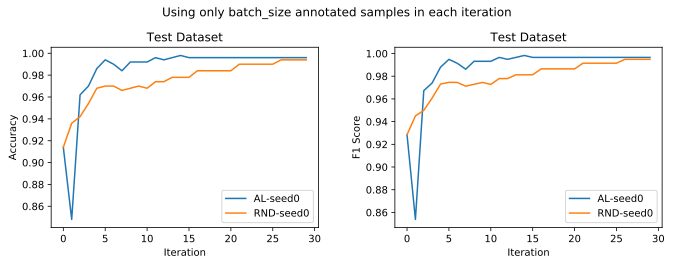

In [25]:
import matplotlib.pyplot as plt

AL_performance0 = strategy_results['uncertainty']
RND_performance0 = strategy_results['random']

plt.figure(figsize=(10,4))
plt.suptitle('Using only batch_size annotated samples in each iteration')
plt.subplot(121)
plt.plot(range(len(AL_performance0[0])-1), AL_performance0[0][:-1], label='AL-seed0')
plt.plot(range(len(RND_performance0[0])-1), RND_performance0[0][:-1], label='RND-seed0')
plt.title('Test Dataset')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(len(AL_performance0[1])-1), AL_performance0[1][:-1], label='AL-seed0')
plt.plot(range(len(RND_performance0[1])-1), RND_performance0[1][:-1], label='RND-seed0')

plt.legend()
plt.title('Test Dataset')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')


plt.tight_layout(pad=3.0)

%config InlineBackend.figure_format = 'svg'

# plt.savefig('Results-annotated_i.svg', format='svg')
plt.show()

In [31]:
pickle.dump(eval_metrics, open('bert_svm_eval_metrics-Rnd.pkl', 'wb'))

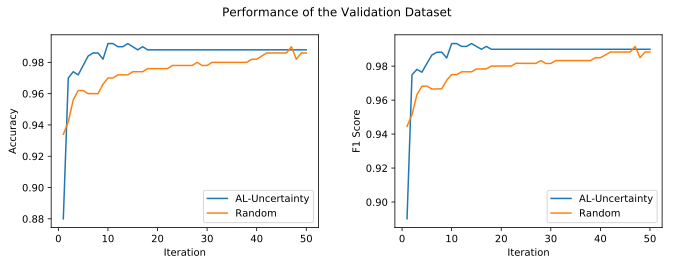

In [32]:
ALU_performance = np.asarray(pickle.load(open('bert_svm_eval_metrics-ALU.pkl', 'rb')))
RND_performance = np.asarray(pickle.load(open('bert_svm_eval_metrics-Rnd.pkl', 'rb')))

#### VALIDATION
plt.figure(figsize=(10,4))
plt.suptitle('Performance of the Validation Dataset')
plt.subplot(121)
plt.plot(range(1, len(ALU_performance)), ALU_performance[1:, 2], label='AL-Uncertainty')
plt.plot(range(1, len(RND_performance)), RND_performance[1:, 2], label='Random')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(1, len(ALU_performance)), ALU_performance[1:, 3], label='AL-Uncertainty')
plt.plot(range(1, len(RND_performance)), RND_performance[1:, 3], label='Random')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('F1 Score')

plt.tight_layout(pad=3.0)
%config InlineBackend.figure_format = 'svg'

plt.savefig('Results-xgb-valid.svg', format='svg')
plt.show()
